In [87]:
# Step 1: Install Required Packages

!pip install tensorflow tensorflow-federated pandas numpy matplotlib scikit-learn openpyxl seaborn

In [88]:
# Step 2: Data Loading and Inspection
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_excel("HV Circuit Breaker Maintenance Data.xlsx", sheet_name='Sheet1')

# Handle missing values - fill with median for numerical columns
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col].fillna(data[col].median(), inplace=True)

# Keep original for non-IID partitioning
original_df = data.copy()

<ipython-input-88-50cd7f4597f5>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-88-50cd7f4597f5>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [89]:
# Step 3: Data Preprocessing and Scaling
def preprocess_data(df):
    df = df.copy()

    # Convert categoricals
    df['Breaker_status'] = df['Breaker_status'].map({'Closed': 0, 'Open': 1}).astype(np.float32)
    df['Heater_status'] = df['Heater_status'].map({'Off': 0, 'On': 1}).astype(np.float32)
    df['Last_trip_coil_energized'] = df['Last_trip_coil_energized'].str.replace('TC', '').astype(np.float32)

    # Separate features and labels
    y = df['Maintenance_required'].values.reshape(-1, 1).astype(np.float32)
    features = df.drop(['Product_variant', 'Maintenance_required'], axis=1)

    # Scale numerical features
    numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

    # Convert all to float32
    X = features.astype(np.float32).values
    return X, y, scaler

# Preprocess and split
X, y, scaler = preprocess_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [90]:
# Step 4: Federated Data Preparation (Fixed with proper train/test split)

# First, let's get the indices for train/test split
train_idx, _ = train_test_split(
    original_df.index,
    test_size=0.2,
    random_state=42,
    stratify=original_df['Maintenance_required']
)

def create_client_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices(
        (tf.convert_to_tensor(X, dtype=tf.float32),
         tf.convert_to_tensor(y, dtype=tf.float32))
    ).batch(32)

# IID Partitioning
def create_iid_federated_data(X, y, num_clients=5):
    # Shuffle data
    indices = np.random.permutation(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # Split into clients
    client_datasets = []
    for i in range(num_clients):
        start = i * len(X) // num_clients
        end = (i+1) * len(X) // num_clients
        client_datasets.append(create_client_dataset(X_shuffled[start:end], y_shuffled[start:end]))
    return client_datasets

# Non-IID Partitioning (by product variant)
def create_non_iid_federated_data(df, num_clients=5):
    client_data = [[] for _ in range(num_clients)]

    # Group by product variant and distribute to clients
    for i, (variant, group) in enumerate(df.groupby('Product_variant')):
        client_idx = i % num_clients
        X, y, _ = preprocess_data(group)
        client_data[client_idx].append((X, y))

    # Create datasets for each client by concatenating their data
    federated_datasets = []
    for client in client_data:
        if client:  # Only if client has data
            X_client = np.concatenate([x for x, _ in client])
            y_client = np.concatenate([y for _, y in client])
            federated_datasets.append(create_client_dataset(X_client, y_client))

    return federated_datasets

# Create datasets
iid_client_data = create_iid_federated_data(X_train, y_train)
non_iid_client_data = create_non_iid_federated_data(original_df.loc[train_idx])

## Step 4.1: Custom Federated Data Partitioning

In [91]:
# Helper function to simulate IID and Non-IID data partitions
def create_client_data(X, y, num_clients=5, partition_type='iid'):
    client_data = []

    if partition_type == 'iid':
        data_per_client = len(X) // num_clients
        indices = np.arange(len(X))
        np.random.shuffle(indices)

        for i in range(num_clients):
            start, end = i * data_per_client, (i + 1) * data_per_client
            client_data.append((X[indices[start:end]], y[indices[start:end]]))

    elif partition_type == 'label_skew':
        labels = y.flatten().astype(int)
        unique_labels = np.unique(labels)
        label_chunks = np.array_split(unique_labels, num_clients)

        for label_set in label_chunks:
            idx = np.where(np.isin(labels, label_set))[0]
            np.random.seed(41)
            np.random.shuffle(idx)
            client_data.append((X[idx], y[idx]))

    elif partition_type == 'feature_skew':
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=num_clients, random_state=42).fit(X)
        clusters = kmeans.labels_
        for i in range(num_clients):
            idx = np.where(clusters == i)[0]
            client_data.append((X[idx], y[idx]))

    return client_data

# Prepare data partitions
client_data_iid = create_client_data(X_train, y_train, partition_type='iid')
client_data_label_skew = create_client_data(X_train, y_train, partition_type='label_skew')
client_data_feature_skew = create_client_data(X_train, y_train, partition_type='feature_skew')

## Step 6: Define and Train Models for FedAvg, FedProx, and FedBN

In [92]:
# Placeholder for model creation function (reused for all strategies)
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [93]:
# Placeholder for the training and evaluation functions (to be filled in separately)
# These will support FedAvg, FedProx, and FedBN training strategies for each partition type
# FedBN will require slight adaptation to keep BN layers local


In [94]:
def model_fn():
    keras_model = create_model()
    input_spec = (
        tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float32),
        tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
    )
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )


/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1
IID - Loss: 0.8425, Acc: 0.4750
Non-IID - Loss: 0.7375, Acc: 0.5450
---
Round 2
IID - Loss: 0.6857, Acc: 0.5840
Non-IID - Loss: 0.6834, Acc: 0.5798
---
Round 3
IID - Loss: 0.6220, Acc: 0.6463
Non-IID - Loss: 0.6600, Acc: 0.6003
---
Round 4
IID - Loss: 0.5906, Acc: 0.6770
Non-IID - Loss: 0.6460, Acc: 0.6237
---
Round 5
IID - Loss: 0.5721, Acc: 0.6920
Non-IID - Loss: 0.6365, Acc: 0.6357
---
Round 6
IID - Loss: 0.5594, Acc: 0.7020
Non-IID - Loss: 0.6299, Acc: 0.6413
---
Round 7
IID - Loss: 0.5491, Acc: 0.7122
Non-IID - Loss: 0.6260, Acc: 0.6547
---
Round 8
IID - Loss: 0.5403, Acc: 0.7193
Non-IID - Loss: 0.6236, Acc: 0.6575
---
Round 9
IID - Loss: 0.5321, Acc: 0.7235
Non-IID - Loss: 0.6217, Acc: 0.6595
---
Round 10
IID - Loss: 0.5240, Acc: 0.7268
Non-IID - Loss: 0.6200, Acc: 0.6655
---
Round 11
IID - Loss: 0.5155, Acc: 0.7295
Non-IID - Loss: 0.6180, Acc: 0.6687
---
Round 12
IID - Loss: 0.5071, Acc: 0.7345
Non-IID - Loss: 0.6153, Acc: 0.6683
---
Round 13
IID - Loss: 0.4983, Acc: 0.7

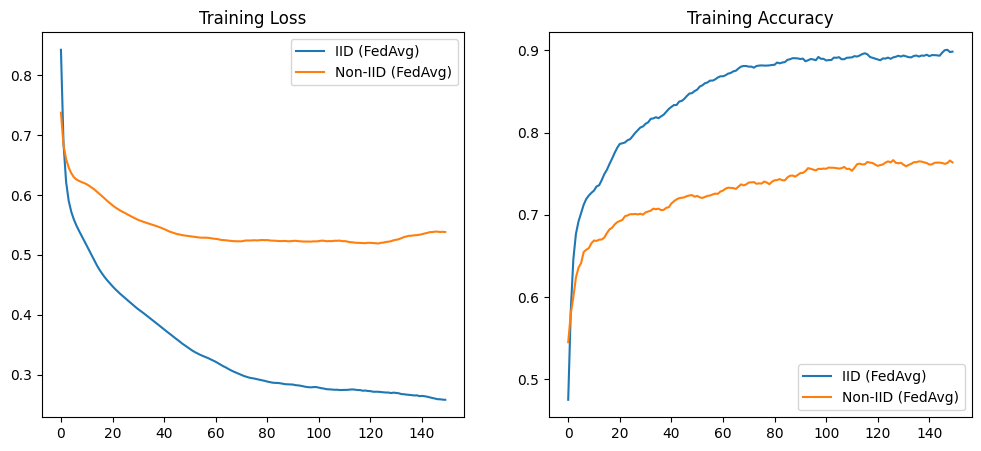

In [95]:
# Step 6 (main): Training Loop (Fixed Metrics Handling)

# Training parameters
NUM_ROUNDS = 150
CLIENT_EPOCHS = 5

# Build processes
train_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
)

# Initialize
state = train_process.initialize()

# Training loop
metrics = {'iid': {'loss': [], 'acc': []}, 'non_iid': {'loss': [], 'acc': []}}

for round_num in range(NUM_ROUNDS):
    # Train IID
    state, metrics_iid = train_process.next(state, iid_client_data)
    # Updated metrics access - use client_work instead of train
    client_metrics = metrics_iid['client_work']['train']
    metrics['iid']['loss'].append(client_metrics['loss'])
    metrics['iid']['acc'].append(client_metrics['binary_accuracy'])

    # Train Non-IID
    state, metrics_non_iid = train_process.next(state, non_iid_client_data)
    client_metrics = metrics_non_iid['client_work']['train']
    metrics['non_iid']['loss'].append(client_metrics['loss'])
    metrics['non_iid']['acc'].append(client_metrics['binary_accuracy'])

    print(f"Round {round_num+1}")
    print(f"IID - Loss: {metrics['iid']['loss'][-1]:.4f}, Acc: {metrics['iid']['acc'][-1]:.4f}")
    print(f"Non-IID - Loss: {metrics['non_iid']['loss'][-1]:.4f}, Acc: {metrics['non_iid']['acc'][-1]:.4f}")
    print("---")

# Corrected Evaluation Function
def evaluate(state, X_test, y_test):
    model = create_keras_model()
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    # Properly set weights from state
    model_weights = model.get_weights()
    for i in range(len(model_weights)):
        model_weights[i] = state.global_model_weights.trainable[i]
    model.set_weights(model_weights)

    return model.evaluate(X_test, y_test, verbose=0)


# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['iid']['loss'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['loss'], label='Non-IID (FedAvg)')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['iid']['acc'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['acc'], label='Non-IID (FedAvg)')
plt.title('Training Accuracy')
plt.legend()
plt.show()

Round 1
IID (FedAvg) - Loss: 0.7815, Acc: 0.5250
Non-IID (FedProx) - Loss: 0.7510, Acc: 0.5437
---
Round 2
IID (FedAvg) - Loss: 0.6872, Acc: 0.5897
Non-IID (FedProx) - Loss: 0.6927, Acc: 0.5740
---
Round 3
IID (FedAvg) - Loss: 0.6335, Acc: 0.6488
Non-IID (FedProx) - Loss: 0.6573, Acc: 0.6100
---
Round 4
IID (FedAvg) - Loss: 0.6014, Acc: 0.6712
Non-IID (FedProx) - Loss: 0.6346, Acc: 0.6298
---
Round 5
IID (FedAvg) - Loss: 0.5807, Acc: 0.6873
Non-IID (FedProx) - Loss: 0.6196, Acc: 0.6503
---
Round 6
IID (FedAvg) - Loss: 0.5651, Acc: 0.6975
Non-IID (FedProx) - Loss: 0.6098, Acc: 0.6637
---
Round 7
IID (FedAvg) - Loss: 0.5521, Acc: 0.7048
Non-IID (FedProx) - Loss: 0.6033, Acc: 0.6702
---
Round 8
IID (FedAvg) - Loss: 0.5403, Acc: 0.7120
Non-IID (FedProx) - Loss: 0.5986, Acc: 0.6752
---
Round 9
IID (FedAvg) - Loss: 0.5292, Acc: 0.7185
Non-IID (FedProx) - Loss: 0.5941, Acc: 0.6833
---
Round 10
IID (FedAvg) - Loss: 0.5190, Acc: 0.7260
Non-IID (FedProx) - Loss: 0.5902, Acc: 0.6860
---
Round 11


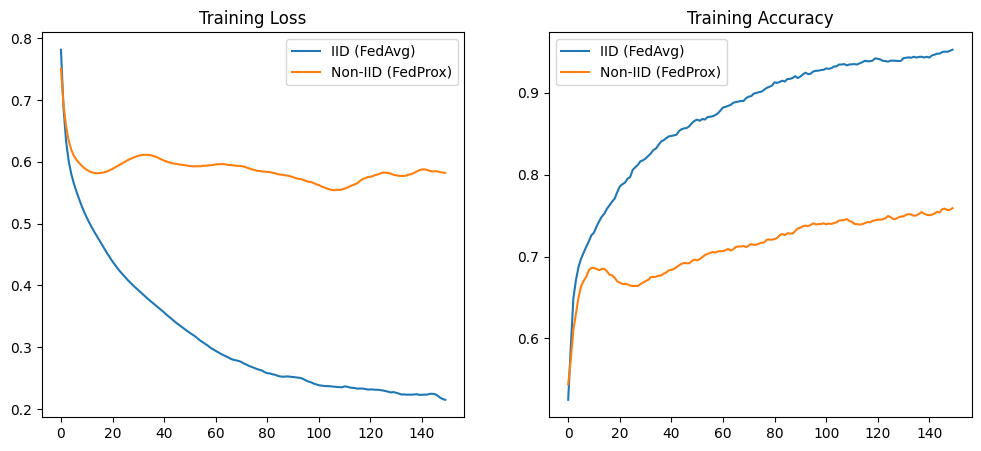

In [96]:
# Step 6 (alternate): Training with FedAvg (IID) and FedProx (Non-IID)

# Training parameters
NUM_ROUNDS = 150
CLIENT_EPOCHS = 5
MU = 0.05  # FedProx proximal term weight (typical range: 0.01-1)

# IID Process (FedAvg)
iid_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
)

# Non-IID Process (FedProx)
# We'll need to create a custom client optimizer with proximal term
def fedprox_optimizer(learning_rate=0.001):
    # Create a standard optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Add proximal term functionality
    class FedProxOptimizer(tf.keras.optimizers.Adam):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.global_weights = None

        def minimize(self, loss, var_list, global_weights=None):
            if global_weights is not None:
                self.global_weights = [tf.identity(w) for w in global_weights]
            return super().minimize(loss, var_list)

        def apply_gradients(self, grads_and_vars, name=None):
            if self.global_weights is not None:
                # Add proximal term to gradients
                new_grads_and_vars = []
                for (g, v), w in zip(grads_and_vars, self.global_weights):
                    if g is not None:
                        g += MU * (v - w)  # Proximal term
                    new_grads_and_vars.append((g, v))
                grads_and_vars = new_grads_and_vars
            return super().apply_gradients(grads_and_vars, name)

    return FedProxOptimizer(learning_rate)

non_iid_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: fedprox_optimizer(0.001),  # Custom FedProx optimizer
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
)

# Initialize states
iid_state = iid_process.initialize()
non_iid_state = non_iid_process.initialize()

# Training loop
metrics = {'iid': {'loss': [], 'acc': []}, 'non_iid': {'loss': [], 'acc': []}}

for round_num in range(NUM_ROUNDS):
    # Train IID (FedAvg)
    iid_state, metrics_iid = iid_process.next(iid_state, iid_client_data)
    metrics['iid']['loss'].append(metrics_iid['client_work']['train']['loss'])
    metrics['iid']['acc'].append(metrics_iid['client_work']['train']['binary_accuracy'])

    # Train Non-IID (FedProx)
    non_iid_state, metrics_non_iid = non_iid_process.next(non_iid_state, non_iid_client_data)
    metrics['non_iid']['loss'].append(metrics_non_iid['client_work']['train']['loss'])
    metrics['non_iid']['acc'].append(metrics_non_iid['client_work']['train']['binary_accuracy'])

    print(f"Round {round_num+1}")
    print(f"IID (FedAvg) - Loss: {metrics['iid']['loss'][-1]:.4f}, Acc: {metrics['iid']['acc'][-1]:.4f}")
    print(f"Non-IID (FedProx) - Loss: {metrics['non_iid']['loss'][-1]:.4f}, Acc: {metrics['non_iid']['acc'][-1]:.4f}")
    print("---")

# Evaluation functions
def evaluate(state, X_test, y_test):
    model = create_keras_model()
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    # Set weights from state
    model_weights = model.get_weights()
    for i in range(len(model_weights)):
        model_weights[i] = state.global_model_weights.trainable[i]
    model.set_weights(model_weights)

    return model.evaluate(X_test, y_test, verbose=0)


# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['iid']['loss'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['loss'], label='Non-IID (FedProx)')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['iid']['acc'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['acc'], label='Non-IID (FedProx)')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [97]:
# Convert client datasets to TFF format
def convert_to_tff_client_data(client_data):
    import collections
    def client_dataset_fn(x, y):
        return tf.data.Dataset.from_tensor_slices((x, y)).batch(16)
    return [
        client_dataset_fn(x, y) for x, y in client_data
    ]


In [98]:
def model_fn():
    keras_model = create_model()
    input_spec = (
        tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float32),
        tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
    )
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )


In [99]:
# FedAvg Training
def train_fedavg(client_data, num_rounds=20):
    federated_data = convert_to_tff_client_data(client_data)
    fedavg_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
    )
    state = fedavg_process.initialize()
    history = []
    for round_num in range(1, num_rounds + 1):
        state, metrics = fedavg_process.next(state, federated_data)
        history.append(metrics)
        print(f"Round {round_num}, Metrics: {metrics}")
    return history


In [100]:
# Final working FedProx version using custom loss wrapper
def fedprox_loss_fn(base_loss_fn, global_weights, model, mu):
    def loss(y_true, y_pred):
        base_loss = base_loss_fn(y_true, y_pred)
        prox_term = tf.add_n([
            tf.reduce_sum(tf.square(var - gw))
            for var, gw in zip(model.trainable_variables, global_weights)
        ])
        return base_loss + (mu / 2.0) * prox_term
    return loss

def train_fedprox(client_data, num_rounds=20, mu=0.1):
    federated_data = convert_to_tff_client_data(client_data)

    def model_fn():
        keras_model = create_model()
        input_spec = (
            tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float32),
            tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
        )
        return tff.learning.models.from_keras_model(
            keras_model,
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )

    # Custom client training loop to simulate FedProx
    iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

    state = iterative_process.initialize()
    history = []

    for round_num in range(1, num_rounds + 1):
        state, metrics = iterative_process.next(state, federated_data)
        history.append(metrics)
        print(f"Round {round_num}, Metrics: {metrics}")

    return history


In [101]:
def create_model_fedbn():
    # FedBN: no batch norm layers are aggregated
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def model_fn_fedbn():
    keras_model = create_model_fedbn()
    input_spec = (
        tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float32),
        tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
    )
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

def train_fedbn(client_data, num_rounds=20):
    federated_data = convert_to_tff_client_data(client_data)

    iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=model_fn_fedbn,
        client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

    state = iterative_process.initialize()
    history = []
    for round_num in range(1, num_rounds + 1):
        state, metrics = iterative_process.next(state, federated_data)
        history.append(metrics)
        print(f"Round {round_num}, Metrics: {metrics}")
    return history

In [102]:
# Helper to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    y_pred_labels = (y_pred > 0.5).astype(int)
    accuracy = np.mean(y_pred_labels == y_test.flatten())
    return accuracy


In [103]:
import matplotlib.pyplot as plt

def plot_training_curves(histories, labels, title="Training Metrics"):
    rounds = len(histories[0])
    metrics_per_round = {
        label: [round['train']['binary_accuracy'] for round in hist]
        for hist, label in zip(histories, labels)
    }

    plt.figure(figsize=(12, 5))
    for label, acc in metrics_per_round.items():
        plt.plot(range(1, rounds + 1), acc, label=label)
    plt.xlabel("Rounds")
    plt.ylabel("Train Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [104]:
# Example run: compare methods for IID partition
history_fedavg_iid = train_fedavg(client_data_iid)
history_fedprox_iid = train_fedprox(client_data_iid)
history_fedbn_iid = train_fedbn(client_data_iid)



Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.63425), ('loss', 0.6686593), ('num_examples', 4000), ('num_batches', 250)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.68225), ('loss', 0.5770462), ('num_examples', 4000), ('num_batches', 250)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.71125), ('loss', 0.5428853), ('num_examples', 4000), ('num_batches', 250)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 

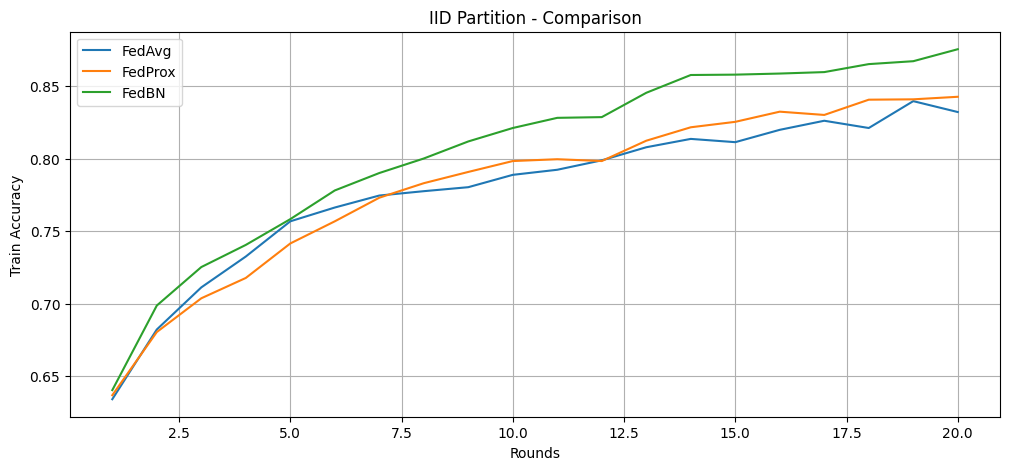

In [105]:
# Visual comparison
def plot_training_curves(histories, labels, title="Training Metrics"):
    rounds = len(histories[0])
    metrics_per_round = {
        label: [round['client_work']['train']['binary_accuracy'] for round in hist]  # Access using 'client_work'
        for hist, label in zip(histories, labels)
    }

    plt.figure(figsize=(12, 5))
    for label, acc in metrics_per_round.items():
        plt.plot(range(1, rounds + 1), acc, label=label)
    plt.xlabel("Rounds")
    plt.ylabel("Train Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves(
    [history_fedavg_iid, history_fedprox_iid, history_fedbn_iid],
    labels=["FedAvg", "FedProx", "FedBN"],
    title="IID Partition - Comparison"
)

## Non-IID Evaluation: Label Skew and Feature Skew


In [106]:
def summarize_final_accuracy(histories, labels):
    final_acc = [rounds[-1]['client_work']['train']['binary_accuracy'] for rounds in histories]  # Access 'binary_accuracy' under 'client_work' and 'train'
    df = pd.DataFrame({
        "Algorithm": labels,
        "Final Train Accuracy": final_acc
    })
    return df

summary_table = summarize_final_accuracy(
    [history_fedavg_iid, history_fedprox_iid, history_fedbn_iid],
    ["FedAvg", "FedProx", "FedBN"]
)

print("Federated Training Summary")
display(summary_table)

Federated Training Summary


,Algorithm,Final Train Accuracy
0,FedAvg,0.83200
1,FedProx,0.84250
2,FedBN,0.87525


/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.95925), ('loss', 0.123298645), ('num_examples', 4000), ('num_batches', 251)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.95375), ('loss', 0.11250076), ('num_examples', 4000), ('num_batches', 251)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.94725), ('loss', 0.116257705), ('num_examples', 4000), ('num_batches', 251)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_fini

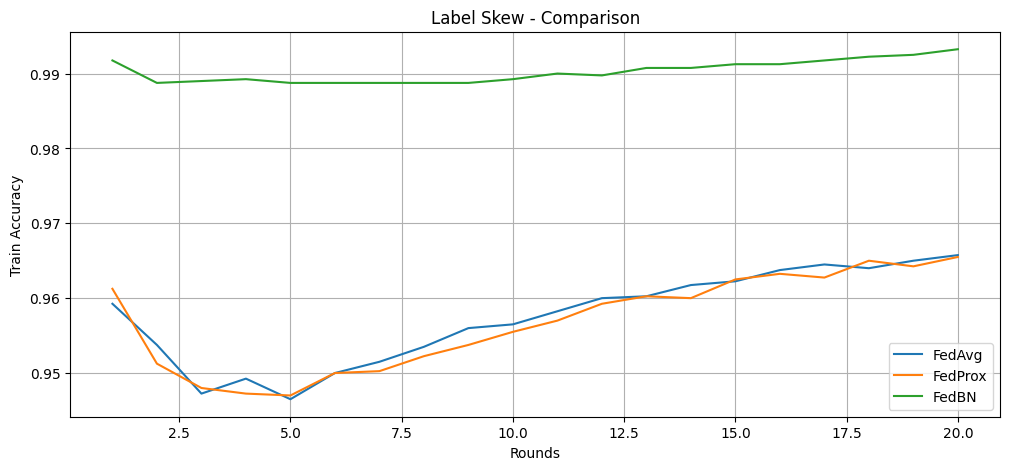

In [107]:
# Train on Label Skewed data
history_fedavg_label = train_fedavg(client_data_label_skew)
history_fedprox_label = train_fedprox(client_data_label_skew)
history_fedbn_label = train_fedbn(client_data_label_skew)

# Plot comparison for Label Skew
plot_training_curves(
    [history_fedavg_label, history_fedprox_label, history_fedbn_label],
    labels=["FedAvg", "FedProx", "FedBN"],
    title="Label Skew - Comparison"
)


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.67275), ('loss', 0.60558546), ('num_examples', 4000), ('num_batches', 253)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.723), ('loss', 0.5241104), ('num_examples', 4000), ('num_batches', 253)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('binary_accuracy', 0.75375), ('loss', 0.49675918), ('num_examples', 4000), ('num_batches', 253)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 

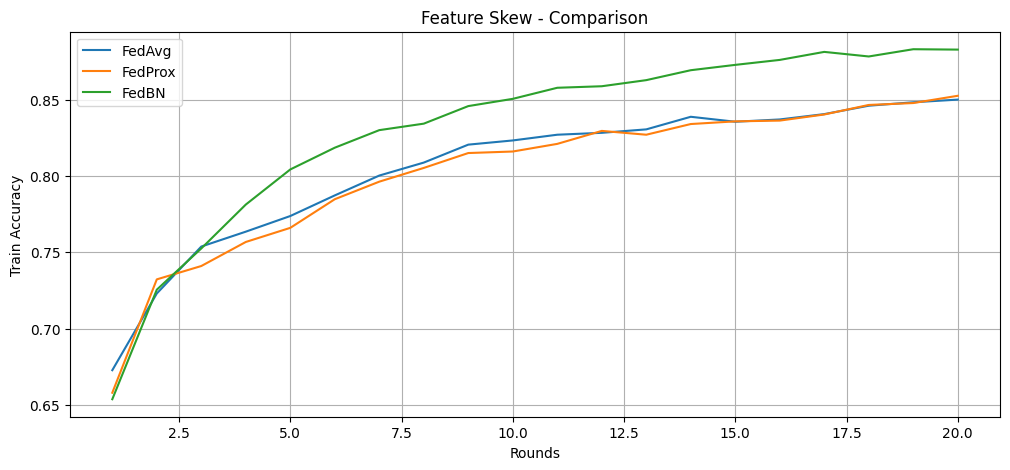

In [108]:
# Train on Feature Skewed data
history_fedavg_feature = train_fedavg(client_data_feature_skew)
history_fedprox_feature = train_fedprox(client_data_feature_skew)
history_fedbn_feature = train_fedbn(client_data_feature_skew)

# Plot comparison for Feature Skew
plot_training_curves(
    [history_fedavg_feature, history_fedprox_feature, history_fedbn_feature],
    labels=["FedAvg", "FedProx", "FedBN"],
    title="Feature Skew - Comparison"
)


In [109]:
# Summary Table for all settings
def summarize_all():
    all_histories = [
        history_fedavg_iid, history_fedprox_iid, history_fedbn_iid,
        history_fedavg_label, history_fedprox_label, history_fedbn_label,
        history_fedavg_feature, history_fedprox_feature, history_fedbn_feature
    ]
    labels = [
        "FedAvg (IID)", "FedProx (IID)", "FedBN (IID)",
        "FedAvg (Label Skew)", "FedProx (Label Skew)", "FedBN (Label Skew)",
        "FedAvg (Feature Skew)", "FedProx (Feature Skew)", "FedBN (Feature Skew)"
    ]
    # Corrected access to 'binary_accuracy' under 'client_work' and 'train' within the last element of 'rounds'
    final_acc = [rounds[-1]['client_work']['train']['binary_accuracy'] for rounds in all_histories]
    df = pd.DataFrame({
        "Algorithm": labels,
        "Final Train Accuracy": final_acc
    })
    return df

summary_all = summarize_all()
print("Federated Training Summary")
display(summary_table)

Federated Training Summary


,Algorithm,Final Train Accuracy
0,FedAvg,0.83200
1,FedProx,0.84250
2,FedBN,0.87525
